In [84]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [85]:
data = pd.read_csv("atlantis_citizens_final.csv")
data = data.dropna(subset=["Occupation"])

In [86]:
data["Wealth_Index"] = (
    data.groupby("District_Name")["Wealth_Index"]
        .transform(lambda x: x.fillna(x.median()))
)

data["House_Size_sq_ft"] = (
    data.groupby("District_Name")["House_Size_sq_ft"]
        .transform(lambda x: x.fillna(x.median()))
)

data["Life_Expectancy"] = (
    data.groupby("District_Name")["Life_Expectancy"]
        .transform(lambda x: x.fillna(x.median()))
)

In [87]:
from sklearn.preprocessing import StandardScaler

X = data.drop(columns=["Citizen_ID","Occupation","Bio_Hash"])

X = pd.get_dummies(X,drop_first=False).astype(np.float32)
X_np = StandardScaler().fit_transform(X)

manual_encoding = {
    "Fisher" : 2,
    "Miner" : 3,
    "Merchant" : 1,
    "Warrior" : 0,
    "Scribe" :4
}

Y = data['Occupation'].map(manual_encoding).to_numpy()

In [88]:
model = Sequential([
    tf.keras.Input(shape=(X_np.shape[1],)),
    Dense(units=80, activation="gelu"),
    # Dense(units=30, activation='sigmoid'),
    # Dense(units=15, activation='sigmoid'),
    Dense(units=len(np.unique(Y)), activation='softmax'),
])

In [89]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 80)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 5)              │           405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,005 (7.83 KB)

 Trainable params: 2,005 (7.83 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

history = model.fit(
    X_np,
    Y,
    epochs=100,

)

Epoch 1/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - accuracy: 0.5402 - loss: 1.1266
Epoch 2/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.6156 - loss: 0.9311
Epoch 3/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.6302 - loss: 0.8965
Epoch 4/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.6298 - loss: 0.8874
Epoch 5/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - accuracy: 0.6288 - loss: 0.8841
Epoch 6/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.6328 - loss: 0.8805
Epoch 7/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - accuracy: 0.6287 - loss: 0.8796
Epoch 8/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.6336 - loss: 0.8786
Epoch 9/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.6322 - loss: 0.8768
Epoch 10/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.6301 - loss: 0.8753
Epoch 11/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.6286 - loss: 0.8740
Epoch 12/100
493/49

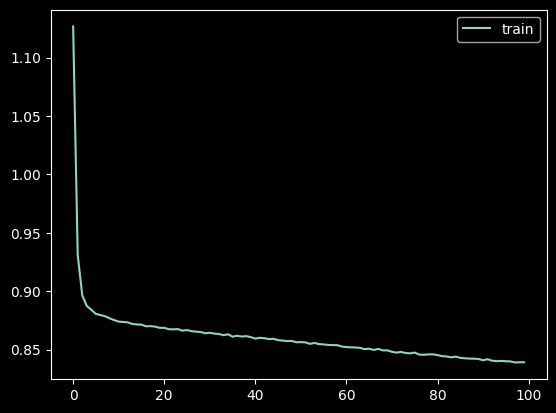

In [91]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train")
plt.legend()
plt.show()
# This cell is to show the plot of loss with respect to the no. of epochs.

In [92]:
test_data = pd.read_csv("test_atlantis_hidden.csv")
X_test = test_data.drop(columns=["Bio_Hash", "Citizen_ID"])

X_test = pd.get_dummies(X_test,drop_first=False).astype(np.float32).to_numpy()
X_test = StandardScaler().fit_transform(X_test)

y_test_probs = model.predict(X_test, batch_size=32)
y_test_pred = np.argmax(y_test_probs, axis=1)
df = pd.DataFrame({
    "Citizen_ID": test_data["Citizen_ID"],
    "Occupation": y_test_pred
})
df.to_csv("prediction.csv", index=False)

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
